In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 1. Collection

## 1.1. Merge Files

In [ ]:
# To be executed on a Colab session
from pathlib import Path
import pandas as pd
import os

# Define directory paths
data_dir = Path('/content/drive/My Drive/EAT40005/Logs')
output_dir = data_dir / 'merge'
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / 'merged_w13.csv'

# Collect all CSV files (excluding previously merged output if exists) - change filepath if needed
csv_files = [f for f in data_dir.glob('*.csv') if f.name != 'merged_w13.csv']

# Merge all CSVs
merged_df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Save to output path
merged_df.to_csv(output_file, index=False)

print(f"Merged {len(csv_files)} files into {output_file}")


Merged 19 files into /content/drive/My Drive/EAT40005/Logs/merge/merged_w13.csv


## 1.2. Data Cleaning

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# 1. Load merged data (with low_memory=False to avoid mixed‐type warnings)
org_dir = Path('/content/drive/My Drive/EAT40005/Logs/merge')
data_path = org_dir / 'merged_w13.csv'
df = pd.read_csv(
    data_path,
    parse_dates=['timestamp'], # identifier
    low_memory=False           # suppresses DtypeWarning
)

# 2. Drop rows with > 4 missing values
max_missing = 4
missing_counts = df.isna().sum(axis=1)
to_drop = missing_counts > max_missing
print(f"– Total rows: {len(df)}")
print(f"– Dropping rows with > {max_missing} missing fields: {to_drop.sum()} rows")
df_cleaned = df.loc[~to_drop].reset_index(drop=True)
df_cleaned = df_cleaned.drop(columns=['road_type', 'traffic_condition', 'FUEL_PRESSURE']) # Incompleted or irrelevant dropping

# 3. List of “numeric” columns you want to impute
numeric_cols = [
    'RPM','THROTTLE_POS','SPEED','ENGINE_LOAD','COOLANT_TEMP',
    'INTAKE_TEMP','MAF','AIRFLOW_PER_RPM','TIMING_ADVANCE','INTAKE_PRESSURE',
    'SHORT_FUEL_TRIM_1','LONG_FUEL_TRIM_1','SHORT_FUEL_TRIM_2','LONG_FUEL_TRIM_2',
    'O2_B1S2','O2_B2S2','O2_S1_WR_VOLTAGE'
]

# 4. Force each of those to numeric (coerce errors → NaN)
for col in numeric_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# 5. Check which “numeric” columns are 100% NaN in df_cleaned
all_nan = df_cleaned[numeric_cols].isna().all()
cols_all_nan = all_nan[all_nan].index.tolist()
print(f"Columns with all NaN (will drop before imputation): {cols_all_nan}")

# 6. Drop any fully‐NaN columns from numeric_cols
numeric_cols_reduced = [c for c in numeric_cols if c not in cols_all_nan]
print(f"– Imputing on {len(numeric_cols_reduced)} numeric columns (dropped {len(cols_all_nan)})")

# 7. Run IterativeImputer on the reduced set
imputer = IterativeImputer(estimator=LinearRegression(), random_state=0, max_iter=10)
imputed_array = imputer.fit_transform(df_cleaned[numeric_cols_reduced])

# 8. Build DataFrame of imputed values
df_imputed_nums = pd.DataFrame(imputed_array, columns=numeric_cols_reduced)

# 9. Reconstruct the final DataFrame:
non_numeric_cols = [c for c in df_cleaned.columns if c not in numeric_cols_reduced]
df_final = pd.concat(
    [df_cleaned[non_numeric_cols].reset_index(drop=True),
     df_imputed_nums.reset_index(drop=True)],
    axis=1
)

# 10. Save out the cleaned+imputed file
output_file = org_dir / 'cleaned_merged_w13.csv'
df_final.to_csv(output_file, index=False)

# 11. Verify no missing values remain in the imputed columns
print("– After imputation, any missing left? ",
      df_final[numeric_cols_reduced].isna().sum().sum())


<ipython-input-17-d01032c6cc2c>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


– Total rows: 111835
– Dropping rows with > 4 missing fields: 481 rows
Columns with all NaN (will drop before imputation): []
– Imputing on 17 numeric columns (dropped 0)
– After imputation, any missing left?  0


# 2. EDA

## 2.1. Basic Overview

In [ ]:
# 2.1.1. View summary statistics
print(df_final[numeric_cols].describe().T)

# 2.1.2. Count missing values per column (should be zero now for numeric_cols)
print(df_final[numeric_cols].isna().sum())

                      count      mean       std       min       25%       50%  \
RPM                111354.0  0.283881  0.144254  0.000000  0.142941  0.293893   
THROTTLE_POS       111354.0  0.084290  0.086914  0.000000  0.028902  0.058824   
SPEED              111354.0  0.353505  0.272753  0.000000  0.099174  0.341463   
ENGINE_LOAD        111354.0  0.191408  0.238819  0.000000  0.038961  0.103896   
COOLANT_TEMP       111354.0  0.768872  0.249016  0.000000  0.706897  0.877193   
INTAKE_TEMP        111354.0  0.375462  0.228576  0.000000  0.205882  0.382353   
MAF                111354.0  0.200612  0.240404  0.000000  0.035733  0.112543   
AIRFLOW_PER_RPM    111354.0  1.112763  3.118971  0.000000  0.151474  0.384206   
TIMING_ADVANCE     111354.0  0.530647  0.265567  0.000000  0.333333  0.535714   
INTAKE_PRESSURE    111354.0  0.231352  0.281573  0.000000  0.056604  0.102564   
SHORT_FUEL_TRIM_1  111354.0  0.594688  0.223356  0.000000  0.480000  0.600000   
LONG_FUEL_TRIM_1   111354.0 

## 2.2. Correlation Heatmap
>**Action**: Note which feature pairs exceed |0.8| correlation. This may inform feature removal or engineered interactions.

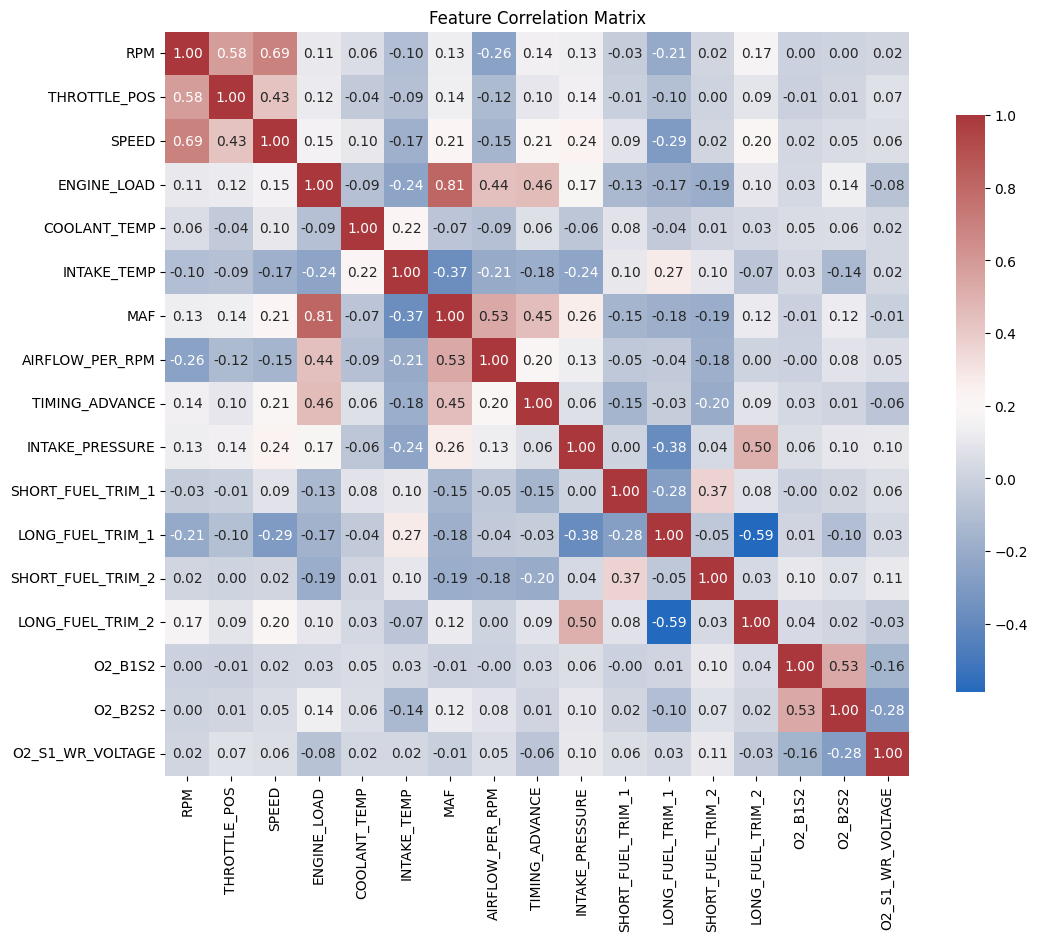

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_final[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", square=True, cbar_kws={'shrink': 0.75})
plt.title("Feature Correlation Matrix")
plt.show()

## 2.3. Distribution Plots (Histograms / KDEs)
> **Action**: Check for skewness, multimodality, heavy tails, etc. This will guide transformations (e.g., log, box‐cox).

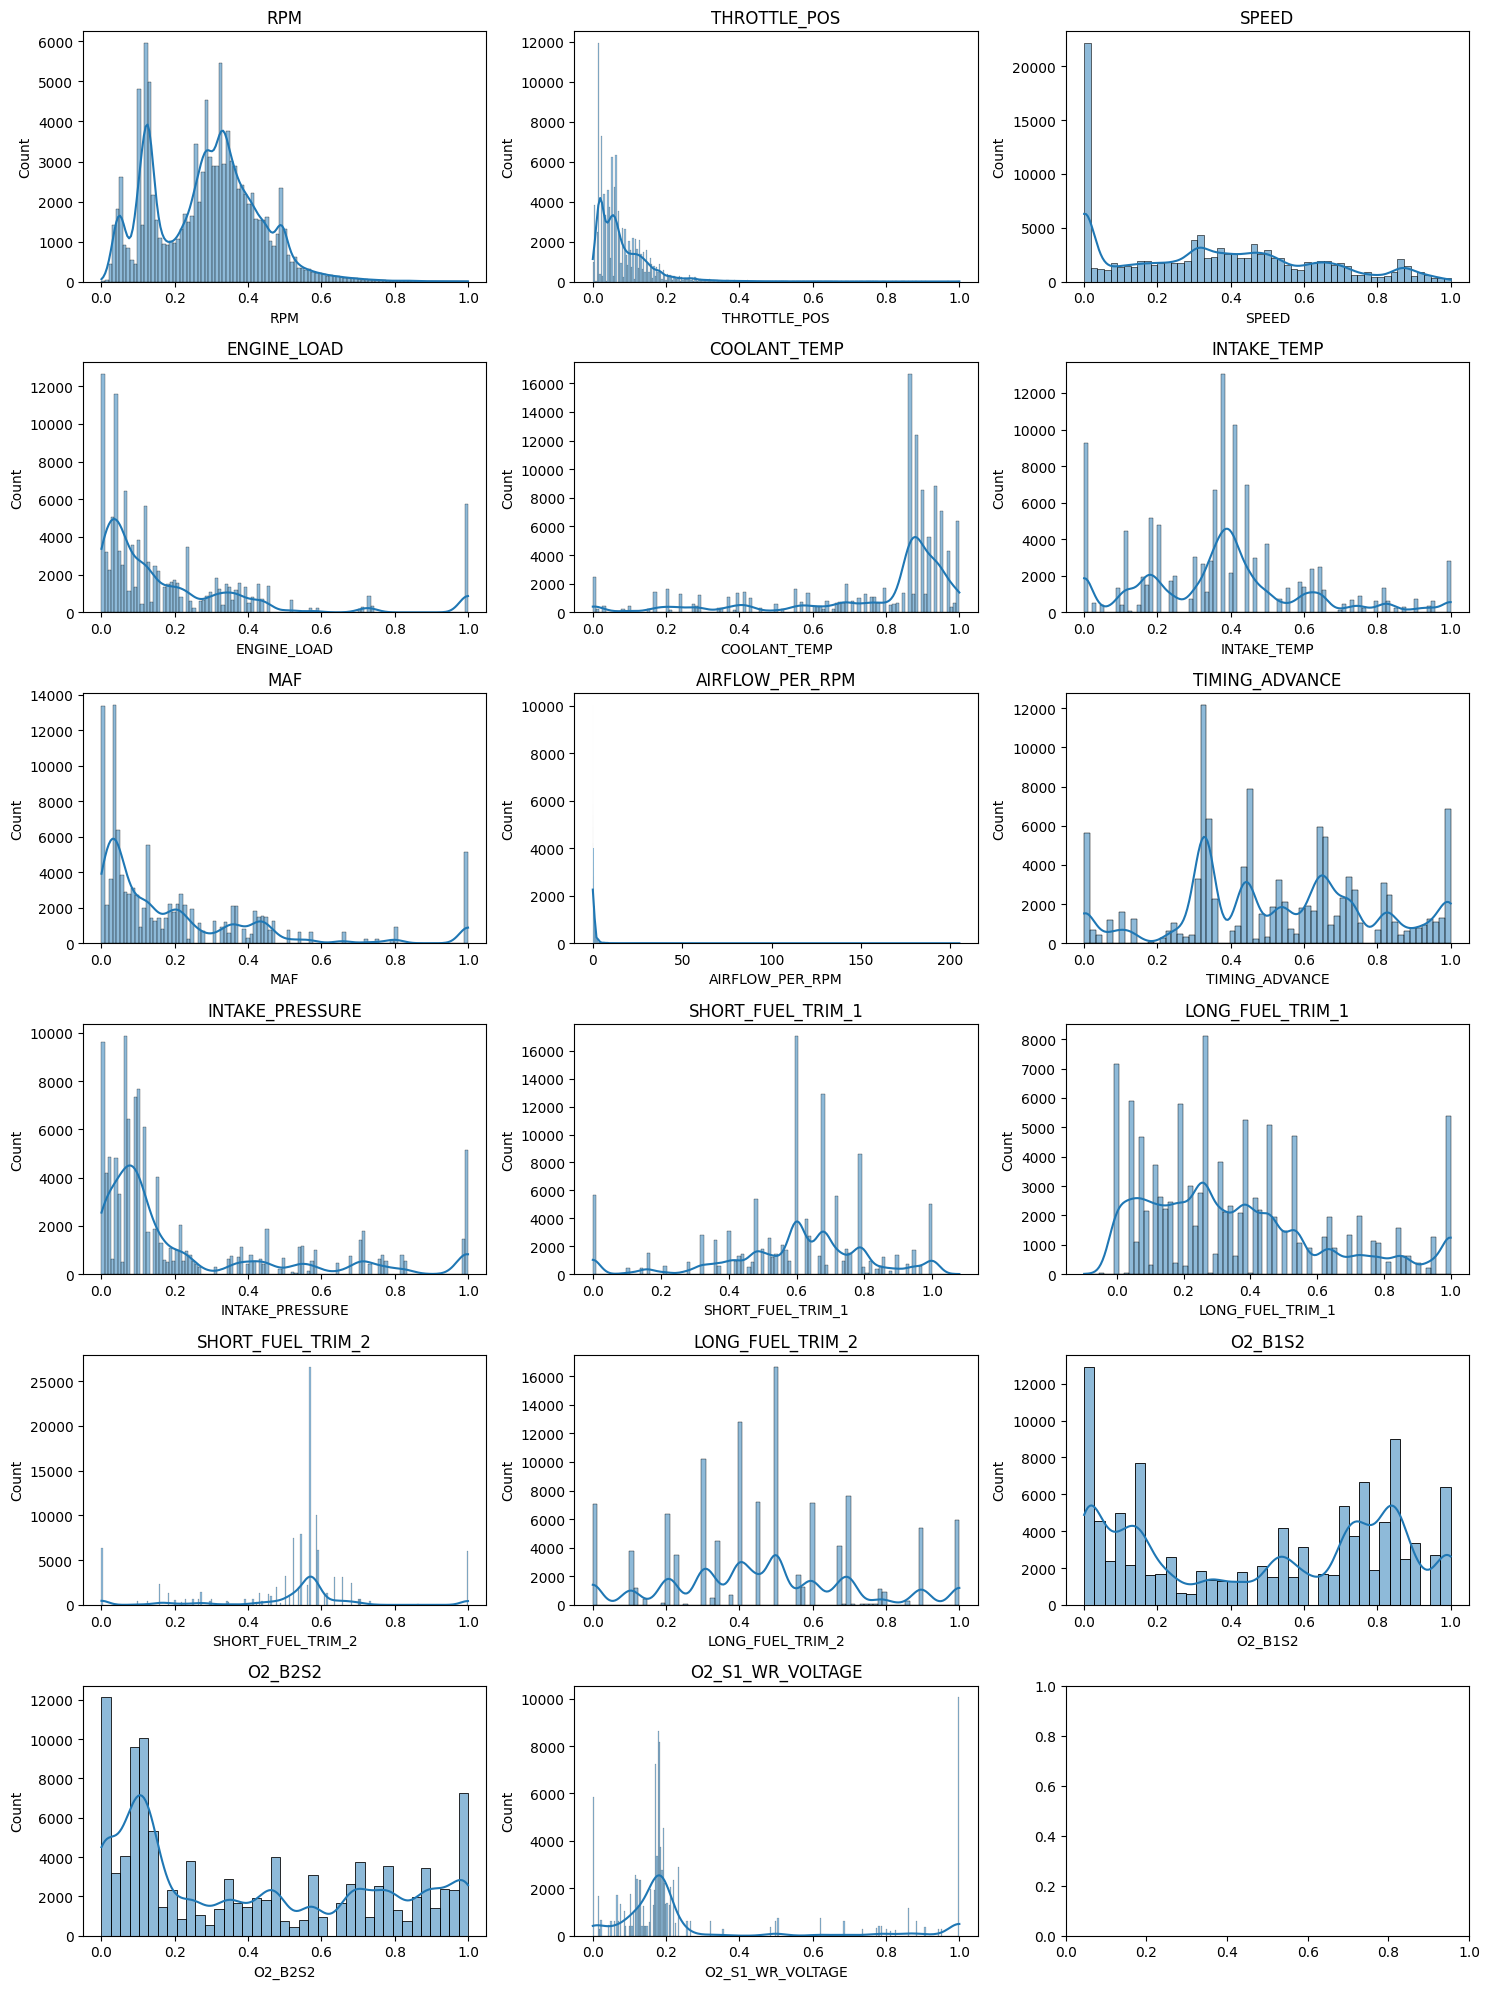

In [ ]:
fig, axes = plt.subplots(len(numeric_cols)//3 + 1, 3, figsize=(15, 20))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df_final[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

## 2.4. Box Plots (Outlier Detection)
> **Action**: Identify any extreme outliers that might need capping or further investigation.

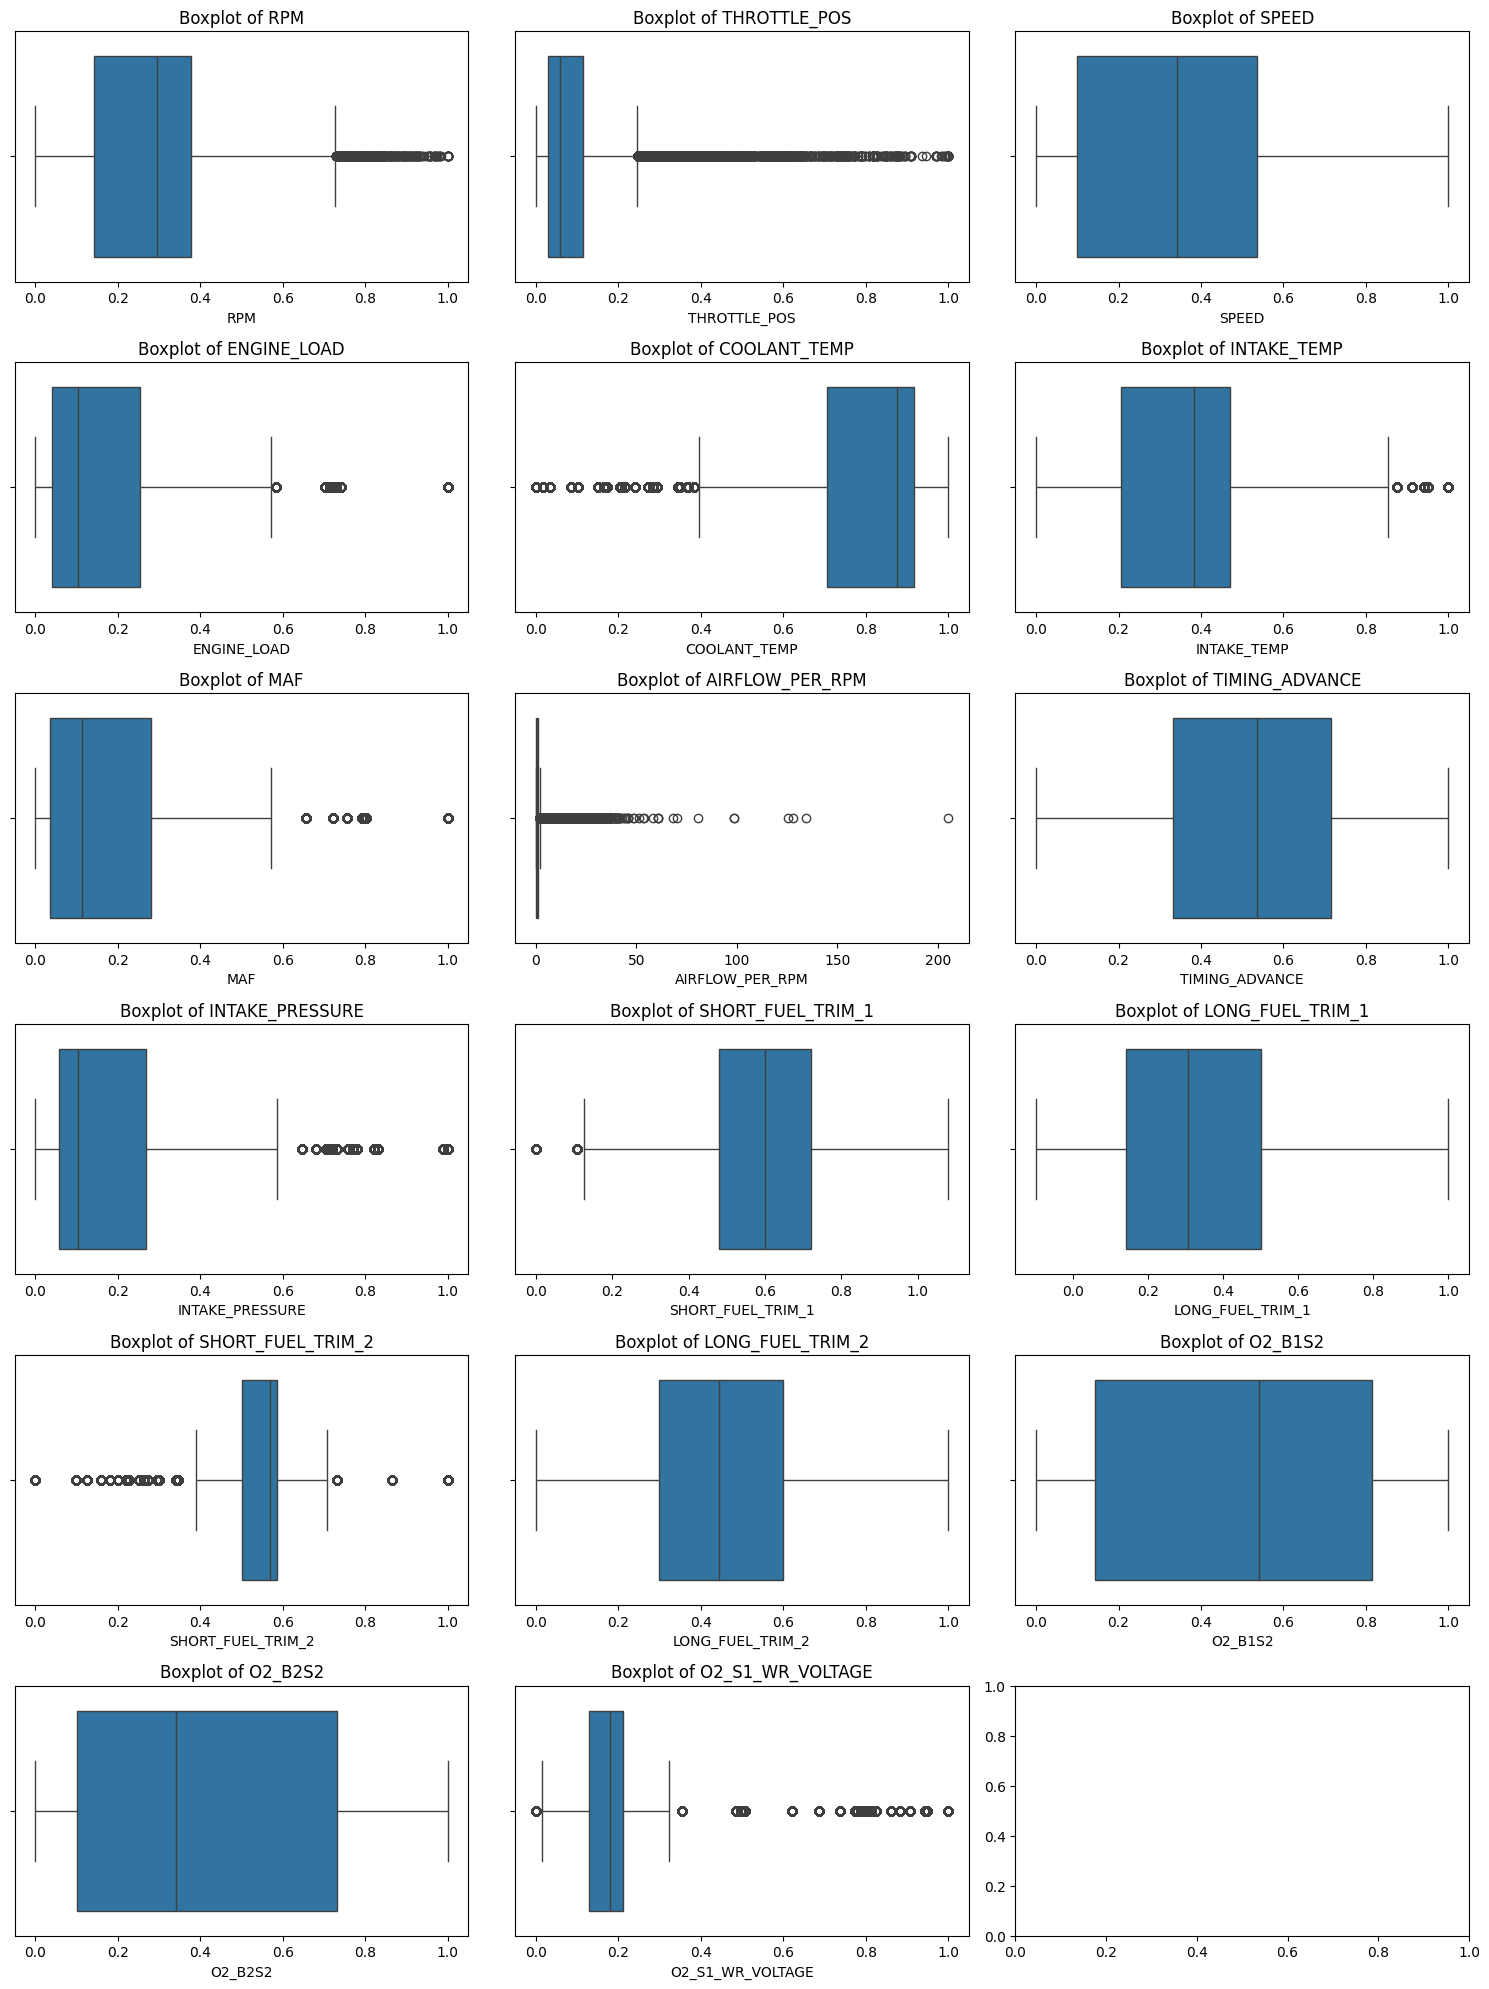

In [ ]:
fig, axes = plt.subplots(len(numeric_cols)//3 + 1, 3, figsize=(15, 20))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_final[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

## 2.5. Time‐Series Patterns
> **Action**: If trend exist (e.g. steady drift in a feature over time), that might indicate degradation. E.g., “creeps upward” or “drops downward” as time passes.

<ipython-input-25-4ec91bed6ba1>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = ts_df[numeric_cols].resample('1H').mean()


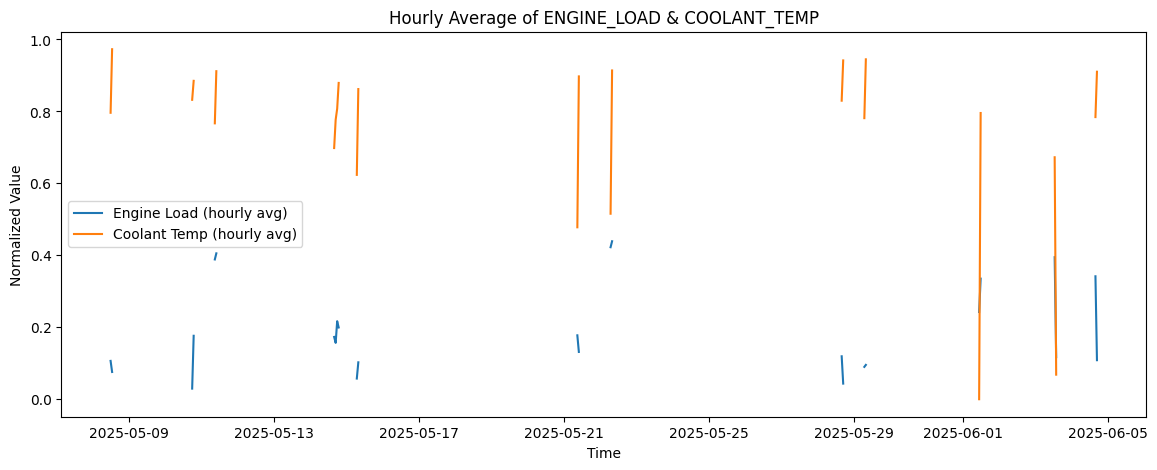

In [ ]:
# Convert timestamp to pandas datetime if not done already
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])

# Resample (for example) hourly means of RPM and SPEED
ts_df = df_final.set_index('timestamp')
hourly = ts_df[numeric_cols].resample('1H').mean()

plt.figure(figsize=(14, 5))
plt.plot(hourly.index, hourly['ENGINE_LOAD'], label='Engine Load (hourly avg)')
plt.plot(hourly.index, hourly['COOLANT_TEMP'], label='Coolant Temp (hourly avg)')
plt.legend()
plt.title("Hourly Average of ENGINE_LOAD & COOLANT_TEMP")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.show()

## 2.6. Pair‐Plot (Scatter Matrix)
> **Action**: Use this to visually confirm any non‐linear relationships, clusters, or obvious anomalies.

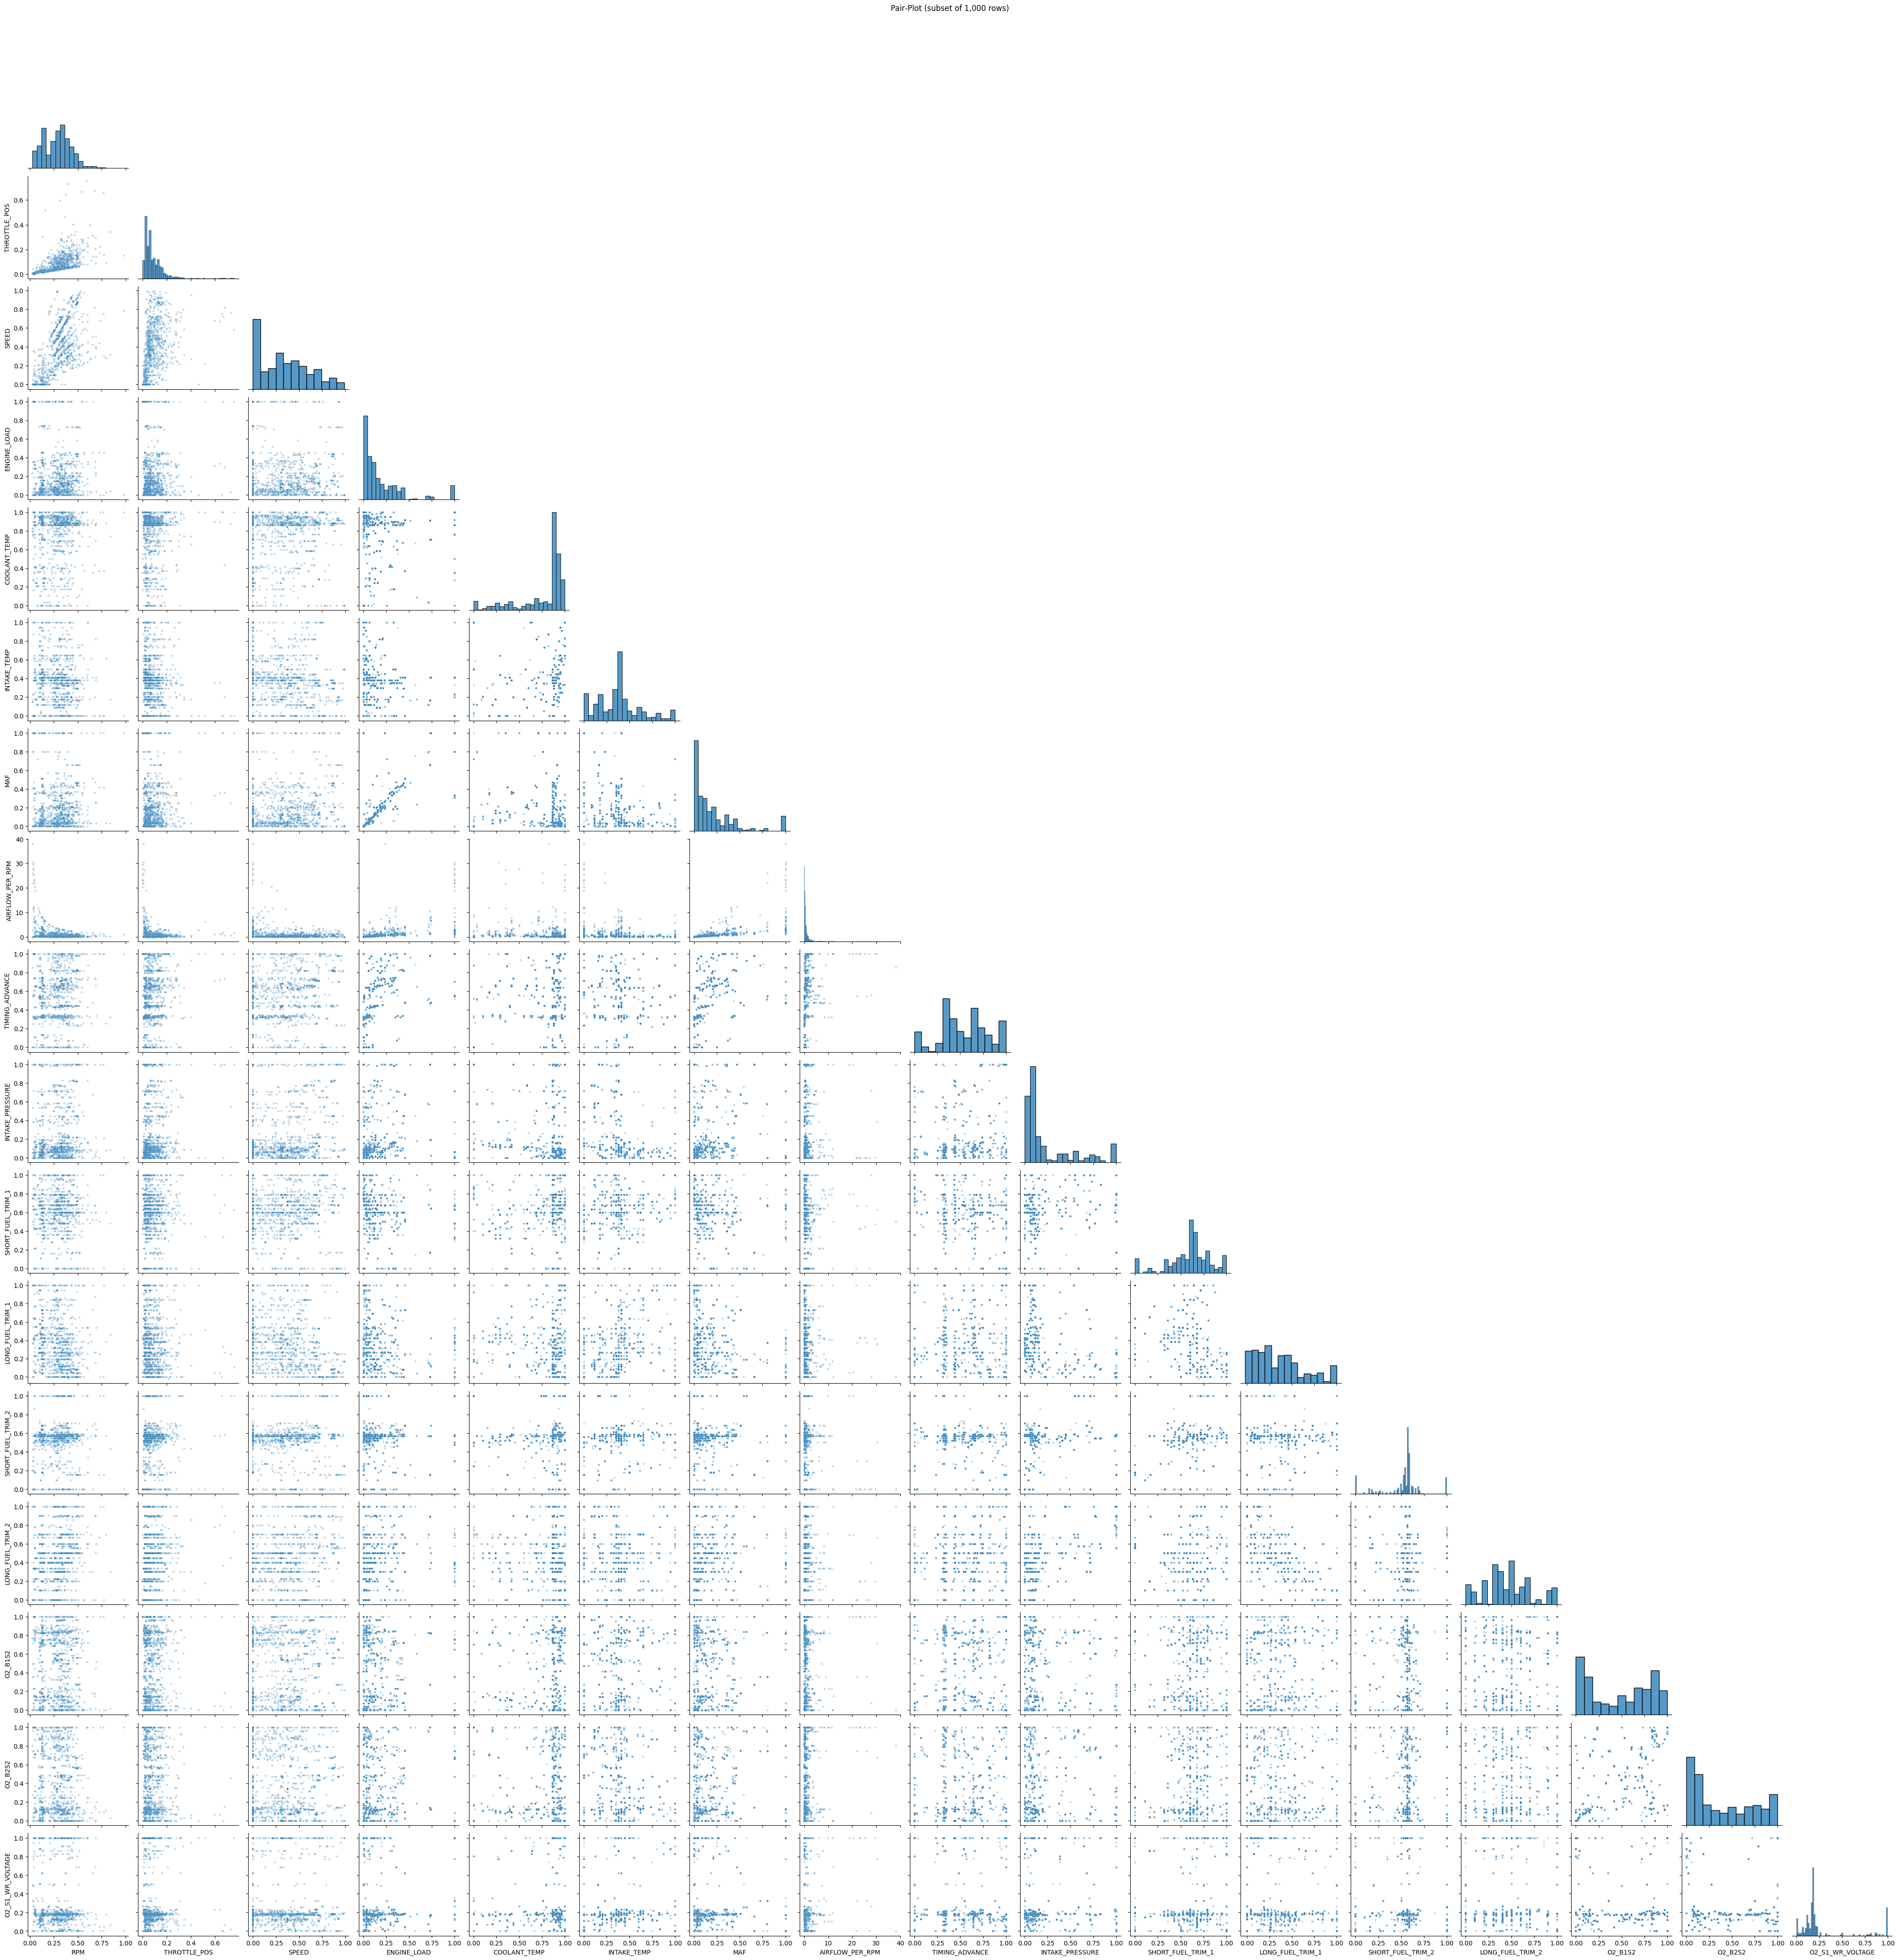

In [ ]:
sns.pairplot(df_final[numeric_cols].sample(1000), corner=True, plot_kws={'alpha':0.3, 's':10})
plt.suptitle("Pair‐Plot (subset of 1,000 rows)", y=1.02)
plt.show()

## 2.7. Principal Component Analysis (PCA) for Outlier Detection
> **Action**: If outliers are too extreme, drop or investigate them.

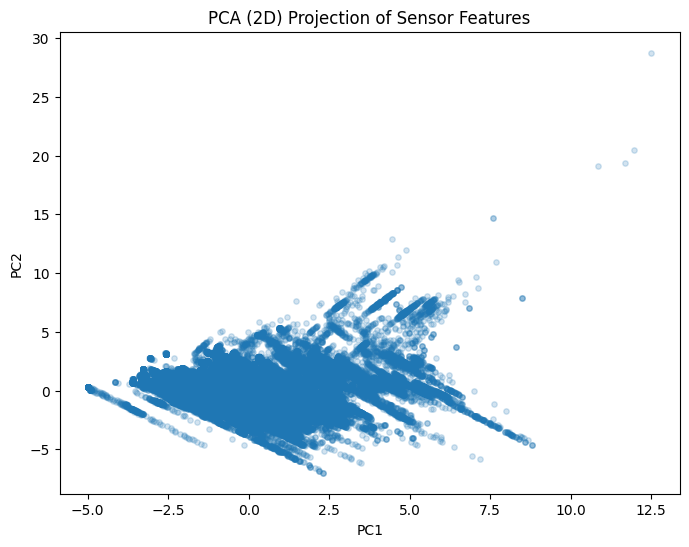

Potential outlier count: 11938


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final[numeric_cols])

pca = PCA(n_components=2, random_state=0)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], alpha=0.2, s=15)
plt.title("PCA (2D) Projection of Sensor Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Identify points with extreme PC scores (e.g. > 3 standard devs)
pc1 = components[:, 0]
pc2 = components[:, 1]
outlier_mask = (abs(pc1) > 3) | (abs(pc2) > 3)
print("Potential outlier count:", outlier_mask.sum())

## *EDA Summary*

### 1. Key Takeaways from EDA
1. **No Remaining Missing Values**

2. **Summary Statistics & Outliers**

   * Many variables are strictly bounded in \[0, 1] (because of auto-normalization pipeline), **except**:

     * `AIRFLOW_PER_RPM` has a long tail (max ≈ 205, 75 % ≈ 0.982).
     * A few trim values (`SHORT_FUEL_TRIM_1`, etc.) slightly exceed 1 (e.g. `SHORT_FUEL_TRIM_1.max` ≈ 1.08).
   * The boxplots confirm heavy outliers in:

     * `AIRFLOW_PER_RPM` (a handful of points > 50).
     * `COOLANT_TEMP` also has a cluster near 0.0 (cold‐engine startup) and another cluster near 1.0 (hot engine).
     * `ENGINE_LOAD` occasionally spikes near 1.0, but most values are below 0.3.
     * `MAF` has some values close to 1.0 (high airflow events).

3. **Strong Correlations (and Potential Redundancies)**

   * **ENGINE\_LOAD ↔ MAF** (corr ≈ 0.81)
   * **SHORT\_FUEL\_TRIM\_2 ↔ LONG\_FUEL\_TRIM\_1** (corr ≈ 0.50)
   * **O2\_B1S2 ↔ O2\_B2S2** (corr ≈ 0.53)
   * **INTAKE\_PRESSURE ↔ LONG\_FUEL\_TRIM\_2** (corr ≈ 0.50)
   * Everything else is mostly |corr| < 0.4.

   In practice, if two features are > 0.8 correlated (like ENGINE\_LOAD & MAF), it often makes sense to either (a) drop one as redundant or (b) combine them (e.g. via PCA) if target method doesn’t mind redundancy.

4. **Distribution Shapes**

   * **Bimodal / Multimodal Patterns**

     * `RPM`: clear peaks around 0.2–0.4 and another small mode above 0.6.
     * `COOLANT_TEMP`: clustered near 0.75–0.9 (hot engine), plus some near 0.0 (cold start).
     * `INTAKE_TEMP`: multiple spikes around 0.3–0.5 (ambient vs. warmed intake).
     * `TIMING_ADVANCE`: heavy center around 0.5, but also peaks near 0.1.
   * **Heavy Tails**

     * `AIRFLOW_PER_RPM` is extremely right‐skewed; most values are < 5, but some reach > 200.
     * `SPEED`: a large cluster near 0.0–0.1, then a “flatter” region 0.3–0.8.
   * **Trim Values**

     * `SHORT_FUEL_TRIM_1` and `SHORT_FUEL_TRIM_2` both cluster near \~ 0.6, with occasional values near 0 and near 1.
     * `LONG_FUEL_TRIM_1` is more uniformly spread between 0–0.5, with some values slightly negative.

5. **Time-Series Patterns**

   * When you plotted **hourly averages** of ENGINE\_LOAD vs. COOLANT\_TEMP, we see “blocks” of operation:

     * Some hours the engine is cold (COOLANT\_TEMP < 0.4), then it rapidly jumps above 0.6–0.8 for long runs.
     * ENGINE\_LOAD also spikes correspondingly, but peaks are usually < 0.6.
   * There isn’t a simple monotonic “wear-over-time” drift—rather, you have multiple drive sessions.

6. **PCA & Outliers**

   * The 2‐D PCA plot shows a wide spread, but a handful of points lie far to the right (PC1 > 10 or PC2 > 20). These are likely the same outliers in `AIRFLOW_PER_RPM` or extreme trim/O₂‐sensor readings.
   * Roughly speaking, anything with |PC1| > 5 or |PC2| > 10 is extremely rare (and could be true malfunction/noise).


# 3. Pre-Target Preprocessing Actions

## 3.1. Outlier Handling & Feature Transformation

In [ ]:
# Cap AIRFLOW_PER_RPM at 99th percentile:
p99 = df_final['AIRFLOW_PER_RPM'].quantile(0.99)
df_final['AIRFLOW_CAPPED'] = df_final['AIRFLOW_PER_RPM'].clip(upper=p99)
# Optionally re‐scale to [0,1]:
df_final['AIRFLOW_CAPPED_NORM'] = (df_final['AIRFLOW_CAPPED'] - df_final['AIRFLOW_CAPPED'].min()) / (df_final['AIRFLOW_CAPPED'].max() - df_final['AIRFLOW_CAPPED'].min())

### Optional (Do not run before final determination)
> Apparently we have some large outliers but not sure if that is noise or actualky represent true high‐stress events,

In [ ]:
# Identify the PCA‐based outliers again (using the same scaler/PCA logic from EDA):
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final[numeric_cols])
pca = PCA(n_components=2, random_state=0)
comps = pca.fit_transform(X_scaled)

outlier_mask = (abs(comps[:,0]) > 5) | (abs(comps[:,1]) > 10)
print("Dropping rows:", outlier_mask.sum())
df_final = df_final.loc[~outlier_mask].reset_index(drop=True)

## 3.2. Feature Selection & Dimensionality Reduction


In [ ]:
# Combine or Drop Highly Correlated Features
# e.g. Combine O2 sensors into O2_COMBO
df_final['O2_COMBO'] = (df_final['O2_B1S2'] + df_final['O2_B2S2']) / 2

# Decide to drop MAF because it's 0.81 correlated with ENGINE_LOAD
df_final.drop(columns=['MAF'], inplace=True)

# 4. Choosing & Engineering a “MaintenanceNeed” Target
> Design approach
> 1. **Rule-Based / Threshold-Based Health Index**
> 2. **Unsupervised Anomaly-Score Approach**

## 4.1. Rule-Based / Threshold-Based Index


A rule‐based approach is **most transparent**. Using your histograms and boxplots, we can identify numerical breakpoints (e.g. “anything above the 90 th percentile is high stress”). Then we convert each feature’s “deviation from normal” into a \[0, 1] stress score and finally combine them (with weights) into a single “HealthIndex” ∈ \[0, 1], which we multiply by 100.

#### 4.1.1. Identify Candidate Features & Thresholds

Based on your EDA, here are a few candidates:

| Feature                                   | 90 th Percentile (approx) | Potential Stress Region | EDA Rationale                                                                                             |
| ----------------------------------------- | ------------------------- | ----------------------- | --------------------------------------------------------------------------------------------------------- |
| **ENGINE\_LOAD**                          | \~ 0.50                   | > 0.5                   | Most values sit < 0.3; when LOAD > 0.5, engine is under high torque/stress.                               |
| **COOLANT\_TEMP**                         | \~ 0.92                   | > 0.92                  | 75 % quantile ≈ 0.916; only heavy operation pushes it near 1.0.                                           |
| **MAF** (or kept as "ENGINE\_LOAD + MAF") | \~ 0.60                   | > 0.6                   | MAF spikes near 0.2–0.3 for normal cruising; > 0.6 indicates very high airflow events.                    |
| **AIRFLOW\_PER\_RPM** (capped)            | \~ 0.50                   | > 0.5                   | After capping at P99 \~ 3.5 and re-norm’d, values above 0.5 are extreme loads.                            |
| **TIMING\_ADVANCE**                       | \~ 0.80                   | < 0.20 or > 0.80        | If timing is retarded or advanced too much (outside \[0.2–0.8] region), may indicate knocking or misfire. |
| **SHORT\_FUEL\_TRIM\_1**                  | \~ 0.80                   | < 0.2 or > 0.8          | Trim values below 0.2 or above 0.8 suggest the ECU is correcting a large AFR error.                       |
| **O2\_COMBO** (average of B1S2 & B2S2)    | \~ 0.80                   | < 0.1 or > 0.8          | Very lean (< 0.1) or very rich (> 0.8) mixtures can indicate sensor or combustion issues.                 |

> **Action (4.1.1)**:
>
> 1. For each numerical feature above, compute its empirical 90 th percentile (or 10 th percentile for lower‐tail alerts).
> 2. Decide whether the “stress region” is only the top tail (e.g. ENGINE\_LOAD > 0.5), or both tails (e.g. Timing too low or too high).

#### 4.1.2. Define a “Stress Function” for Each Feature

For each selected feature $f$, define

$$
s_f(x_f) =
\begin{cases}
0, & \text{if } x_f \text{ in “normal” region} \\[6pt]
\frac{x_f - x_{\text{threshold}}}{1 - x_{\text{threshold}}}, & \text{if } x_f > x_{\text{threshold}} \\[6pt]
\frac{x_{\text{threshold-small} - x_f}}{x_{\text{threshold-small}}}, & \text{if left-tail alert (only for features like TIMING_ADVANCE)} \\
\end{cases}
$$

and then clip $s_f(x)$ to \[0, 1].

Example (ENGINE\_LOAD):

```python
threshold_load = df_final['ENGINE_LOAD'].quantile(0.90)  # ~0.50
def stress_load(x):
    return max(0.0, (x - threshold_load) / (1 - threshold_load))

df_final['Stress_ENGINE_LOAD'] = df_final['ENGINE_LOAD'].apply(stress_load).clip(0, 1)
```

* **COOLANT\_TEMP**:

  ```python
  thresh_ct = df_final['COOLANT_TEMP'].quantile(0.90)  # ~0.92
  def stress_coolant(x):
      return max(0.0, (x - thresh_ct) / (1.0 - thresh_ct))
  df_final['Stress_COOLANT_TEMP'] = df_final['COOLANT_TEMP'].apply(stress_coolant).clip(0, 1)
  ```

* **SHORT\_FUEL\_TRIM\_1** (two‐sided):

  ```python
  low_trim_thresh = df_final['SHORT_FUEL_TRIM_1'].quantile(0.10)    # ~0.2
  high_trim_thresh = df_final['SHORT_FUEL_TRIM_1'].quantile(0.90)   # ~0.8
  def stress_sft1(x):
      if x < low_trim_thresh:
          return (low_trim_thresh - x) / low_trim_thresh
      elif x > high_trim_thresh:
          return (x - high_trim_thresh) / (1 - high_trim_thresh)
      else:
          return 0.0
  df_final['Stress_SHORT_FUEL_TRIM_1'] = df_final['SHORT_FUEL_TRIM_1'].apply(stress_sft1).clip(0, 1)
  ```

Follow the same pattern for each feature you select (e.g. `MAF`, `AIRFLOW_CAPPED_NORM`, `TIMING_ADVANCE`, `O2_COMBO`).

#### 4.1.3. Assign Weights & Aggregate into a Single Index

Once you have $s_f(x_f)\in[0,1]$ for each chosen feature, you need to decide how heavily each factor should contribute to “overall engine stress.” For instance:

| Feature                     | Example Weight $w_f$ | Rationale                                                     |
| --------------------------- | -------------------- | ------------------------------------------------------------- |
| ENGINE\_LOAD                | 0.25                 | Primary mechanical stress on engine.                          |
| COOLANT\_TEMP               | 0.20                 | Overheating risk is critical.                                 |
| MAF (or combined with load) | 0.15                 | Reflects volumetric air flow—important for mixture stress.    |
| AIRFLOW\_CAPPED\_NORM       | 0.15                 | Sudden spikes in airflow can stress intake/turbo.             |
| SHORT\_FUEL\_TRIM\_1        | 0.10                 | ECU is actively correcting mixture—indicator of inefficiency. |
| TIMING\_ADVANCE             | 0.10                 | Large timing deviations can cause knock/wear.                 |
| O2\_COMBO                   | 0.05                 | Indicates stoichiometry problems (lean/rich).                 |

*(Weights must sum to 1.0.)*

Then compute for each row $i$:

$$
\text{HealthIndex}_i = \sum_f w_f \cdot s_f(x_{f,i}), \quad \text{where } 0 \le \text{HealthIndex}_i \le 1.
$$

Finally,

$$
\text{MaintenanceNeed}_i = 100 \times \text{HealthIndex}_i \quad (\in [0,100]).
$$

```python
weights = {
    'Stress_ENGINE_LOAD':       0.25,
    'Stress_COOLANT_TEMP':      0.20,
    'Stress_MAF':               0.15,
    'Stress_AIRFLOW_CAPPED_NORM': 0.15,
    'Stress_SHORT_FUEL_TRIM_1': 0.10,
    'Stress_TIMING_ADVANCE':    0.10,
    'Stress_O2_COMBO':          0.05
}

# Compute weighted sum
stress_cols = list(weights.keys())
df_final['HealthIndex'] = df_final[stress_cols].mul(pd.Series(weights)).sum(axis=1)

# Scale to 0–100
df_final['MaintenanceNeed'] = (df_final['HealthIndex'] * 100).clip(0, 100)
```

> **Action (4.1.3)**:
>
> 1. Choose which features to include (based on EDA, likely ENGINE\_LOAD, COOLANT\_TEMP, MAF, etc.).
> 2. Decide a sensible weight for each (total = 1.0).
> 3. Implement the stress functions, compute `HealthIndex`, and then multiply by 100.



## 4.2. Unsupervised Anomaly-Score Approach




If you’d rather let an algorithm discover “rare / high‐stress” patterns, you can build an **IsolationForest** (or other outlier detector) directly on your normalized features. The advantage is that you don’t have to hand‐craft thresholds; the model will assign each row an “anomaly score.” We can then scale that score into \[0, 100].

#### 4.2.1. Preprocessing for Anomaly Detection

1. **Select Features**

   * Typically, you feed in all numeric columns (or a reduced set). Let’s start with the **subset of sensors** that actually matter for engine health:

     ```python
     features_for_iforest = [
         'ENGINE_LOAD', 'COOLANT_TEMP', 'MAF',
         'AIRFLOW_CAPPED_NORM', 'TIMING_ADVANCE',
         'SHORT_FUEL_TRIM_1', 'O2_COMBO'
     ]
     X = df_final[features_for_iforest].values
     ```
   * If you kept `MAF` + `ENGINE_LOAD` separate or if you dropped MAF (because of high corr), adjust accordingly.

2. **Standardize (Optional but Typical)**

   * IsolationForest is not entirely scale-sensitive (it uses tree splits), but portions of the R‐package documentation suggest standardizing can help if some features dominate. If you did a \[0,1] normalization post‐capping, you may skip true standardization.
   * Otherwise:

     ```python
     from sklearn.preprocessing import StandardScaler
     scaler_if = StandardScaler()
     X_scaled = scaler_if.fit_transform(df_final[features_for_iforest])
     ```

#### 4.2.2. Fit IsolationForest & Extract Anomaly Scores

```python
from sklearn.ensemble import IsolationForest

# 1. Instantiate (tune 'contamination' if you have an idea of what fraction of points should be labeled "maintenance").
iso = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.05,   # e.g., top 5% as anomalies; tune based on your domain
    random_state=42,
    n_jobs=-1
)

# 2. Fit on the selected features
iso.fit(X_scaled if 'X_scaled' in locals() else df_final[features_for_iforest])

# 3. The .score_samples() method returns a negative‐anomaly‐score; higher = more “normal.”
#    We’ll invert it so that “more positive = more anomalous.”
scores = -iso.score_samples(X_scaled if 'X_scaled' in locals() else df_final[features_for_iforest])
df_final['AnomalyScore'] = scores

# 4. Normalize that score to [0,100].
min_s, max_s = scores.min(), scores.max()
df_final['MaintenanceNeed_IForest'] = ((scores - min_s) / (max_s - min_s) * 100).clip(0, 100)
```

#### 4.2.3. Interpret & Validate

* If you set `contamination=0.05`, the top 5 % of rows (by AnomalyScore) will approximate “highest maintenance need.”
* You can inspect a handful of the top‐scoring rows:

  ```python
  df_final.nlargest(10, 'AnomalyScore')[['timestamp', *features_for_iforest, 'MaintenanceNeed_IForest']]
  ```

  and see if they coincide with extreme ENGINE\_LOAD, extremely high COOLANT\_TEMP, etc.

> **Action (4.2.3)**:
>
> 1. Decide a contamination fraction (e.g. 0.05 or 0.02) that makes sense for your use case—roughly the proportion of time you’d expect “maintenance‐level events.”
> 2. Fit the `IsolationForest` and extract the “MaintenanceNeed\_IForest” score.
> 3. Compare those top rows against known maintenance logs (if available) or manual inspection.


# 5. Target Labelling

## 5.1. Rule-base Labelling Approach

In [ ]:
# ┌─────────────────────────────────────────────────────────────────────────┐
# │  Rule-base Labelling.                                                   │
# │  Purpose: Load cleaned_merged_w13.csv, preprocess, compute a rule-based │
# │           MaintenanceNeed (0–100), and save to rule_based.csv           │
# └─────────────────────────────────────────────────────────────────────────┘

import pandas as pd
import numpy as np
from pathlib import Path

df = df_final


# 1) Define Quantile‐Based Thresholds (from your EDA)
#    - 90th percentile for upper‐tail stress signals
th_load   = df['ENGINE_LOAD'].quantile(0.90)    # roughly ~0.50
th_cool   = df['COOLANT_TEMP'].quantile(0.90)   # roughly ~0.92
th_air    = df['AIRFLOW_CAPPED_NORM'].quantile(0.90)
#    - For SHORT_FUEL_TRIM_1, we’ll treat both lower‐10th and upper‐90th as stress
low_trim1  = df['SHORT_FUEL_TRIM_1'].quantile(0.10)
high_trim1 = df['SHORT_FUEL_TRIM_1'].quantile(0.90)
#    - For TIMING_ADVANCE, also treat both tails
low_timing  = df['TIMING_ADVANCE'].quantile(0.10)
high_timing = df['TIMING_ADVANCE'].quantile(0.90)
#    - For O2_COMBO, treat both tails as stress
low_o2  = df['O2_COMBO'].quantile(0.10)
high_o2 = df['O2_COMBO'].quantile(0.90)


# 2) Define “Stress Functions” for each chosen feature
def stress_engine_load(x: float) -> float:
    """0 if x ≤ th_load; otherwise (x - th_load)/(1 - th_load)"""
    return max(0.0, (x - th_load) / (1.0 - th_load))

def stress_coolant(x: float) -> float:
    """0 if x ≤ th_cool; otherwise (x - th_cool)/(1 - th_cool)"""
    return max(0.0, (x - th_cool) / (1.0 - th_cool))

def stress_airflow(x: float) -> float:
    """0 if x ≤ th_air; otherwise (x - th_air)/(1 - th_air)"""
    return max(0.0, (x - th_air) / (1.0 - th_air))

def stress_trim1(x: float) -> float:
    """
    If x < low_trim1, return (low_trim1 - x)/low_trim1.
    If x > high_trim1, return (x - high_trim1)/(1 - high_trim1).
    Otherwise 0.
    """
    if x < low_trim1:
        return (low_trim1 - x) / low_trim1
    elif x > high_trim1:
        return (x - high_trim1) / (1.0 - high_trim1)
    else:
        return 0.0

def stress_timing(x: float) -> float:
    """
    If x < low_timing, return (low_timing - x)/low_timing.
    If x > high_timing, return (x - high_timing)/(1 - high_timing).
    Otherwise 0.
    """
    if x < low_timing:
        return (low_timing - x) / low_timing
    elif x > high_timing:
        return (x - high_timing) / (1.0 - high_timing)
    else:
        return 0.0

def stress_o2(x: float) -> float:
    """
    If x < low_o2, return (low_o2 - x)/low_o2.
    If x > high_o2, return (x - high_o2)/(1 - high_o2).
    Otherwise 0.
    """
    if x < low_o2:
        return (low_o2 - x) / low_o2
    elif x > high_o2:
        return (x - high_o2) / (1.0 - high_o2)
    else:
        return 0.0

# 3) Apply Stress Functions to Create New Columns
df['Stress_ENGINE_LOAD']       = df['ENGINE_LOAD'].apply(stress_engine_load).clip(0,1)
df['Stress_COOLANT_TEMP']      = df['COOLANT_TEMP'].apply(stress_coolant).clip(0,1)
df['Stress_AIRFLOW']           = df['AIRFLOW_CAPPED_NORM'].apply(stress_airflow).clip(0,1)
df['Stress_SHORT_FUEL_TRIM_1'] = df['SHORT_FUEL_TRIM_1'].apply(stress_trim1).clip(0,1)
df['Stress_TIMING_ADVANCE']    = df['TIMING_ADVANCE'].apply(stress_timing).clip(0,1)
df['Stress_O2_COMBO']          = df['O2_COMBO'].apply(stress_o2).clip(0,1)

# 4) Assign Weights for Each Stress Component (must sum to 1)
weights = {
    'Stress_ENGINE_LOAD':       0.25,  # Primary mechanical stress
    'Stress_COOLANT_TEMP':      0.20,  # Overheating risk
    'Stress_AIRFLOW':           0.15,  # Extremes in intake air
    'Stress_SHORT_FUEL_TRIM_1': 0.10,  # Fuel mixture correction
    'Stress_TIMING_ADVANCE':    0.10,  # Knock risk / ign. timing
    'Stress_O2_COMBO':          0.20   # Stoichiometry / sensor health
}

stress_cols = list(weights.keys())

# 5) Compute Weighted HealthIndex ∈ [0, 1], then scale to [0, 100]
df['HealthIndex'] = df[stress_cols].mul(pd.Series(weights)).sum(axis=1)
df['MaintenanceNeed'] = (df['HealthIndex'] * 100).round(2).clip(0, 100)

# 6) Save the full DataFrame (with new target) to rule_based.csv
output_path = Path('/content/drive/My Drive/EAT40005/Logs/merge/rule_based.csv')
df.to_csv(output_path, index=False)

print(f"✅ Rule-Based target computed and saved to:\n  {output_path}")


✅ Rule-Based target computed and saved to:
  /content/drive/My Drive/EAT40005/Logs/merge/rule_based.csv


## 5.2. Unsupervised IsolationForest (Anomaly-Score) Approach

In [ ]:
# ┌──────────────────────────────────────────────────────────────────────────────┐
# │  IsolationForest Labelling.                                                  │
# │  Purpose: Load cleaned_merged_w13.csv, preprocess, fit an IsolationForest to │
# │           produce an anomaly-based MaintenanceNeed (0–100), and save         │
# │           to isolation.csv                                                   │
# └──────────────────────────────────────────────────────────────────────────────┘

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

df = df_final

# 1) Select the features to feed into IsolationForest
features_for_if = [
    'ENGINE_LOAD',
    'COOLANT_TEMP',
    'AIRFLOW_CAPPED_NORM',
    'SHORT_FUEL_TRIM_1',
    'TIMING_ADVANCE',
    'O2_COMBO'
]

X = df[features_for_if].values

# 2) Standardize the feature matrix (optional but recommended for IF)
scaler_if = StandardScaler()
X_scaled = scaler_if.fit_transform(X)

# 3) Fit an IsolationForest—flag approx. top 5% of rows as anomalies
iso = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.05,  # adjust if you expect a different fraction of high‐risk points
    random_state=42,
    n_jobs=-1
)
iso.fit(X_scaled)

# 4) Compute the anomaly score
#    - score_samples() returns “neg_distance_to_cartesian_center” by default (lower = more anomalous)
#    - We invert it so that “higher = more anomalous (higher maintenance need)”
raw_scores = -iso.score_samples(X_scaled)

# 5) Normalize the anomaly scores into [0, 100]
min_s, max_s = raw_scores.min(), raw_scores.max()
df['MaintenanceNeed_IF'] = ((raw_scores - min_s) / (max_s - min_s) * 100).round(2).clip(0, 100)

# 6) Save the full DataFrame (with new MaintenanceNeed_IF) to isolation.csv
output_path = Path('/content/drive/My Drive/EAT40005/Logs/merge/isolation.csv')
df.to_csv(output_path, index=False)

print(f"✅ IsolationForest‐based target computed and saved to:\n  {output_path}")

✅ IsolationForest‐based target computed and saved to:
  /content/drive/My Drive/EAT40005/Logs/merge/isolation.csv


## Summary
> We conclude that IsolationForrest approach deliver better outcome

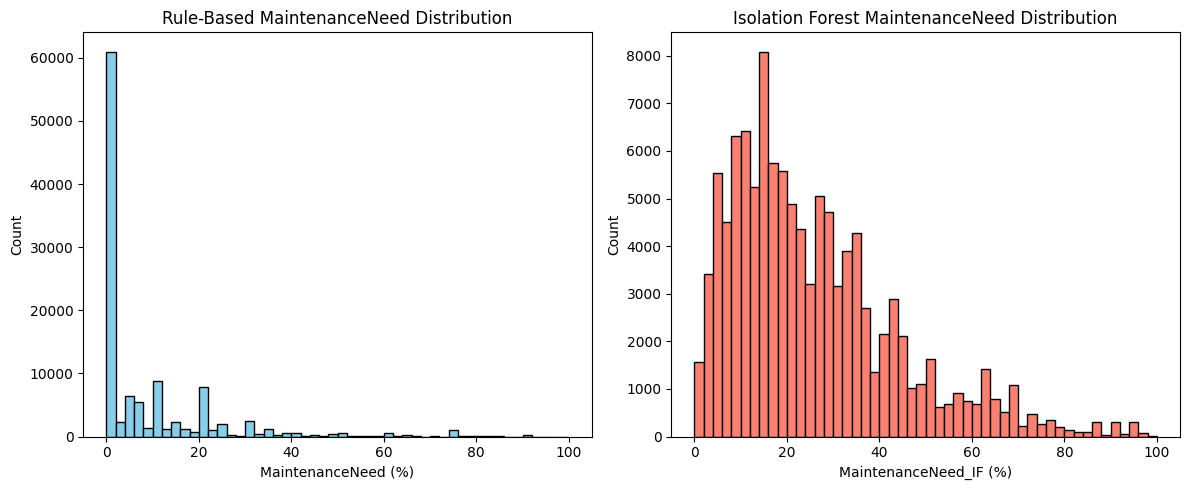

Quantile Summary:
       Rule-Based  IsolationForest
0.00      0.0000             0.00
0.10      0.0000             6.34
0.25      0.0000            12.04
0.50      0.0000            21.26
0.75     10.9500            34.77
0.90     24.8370            50.90
0.95     35.1835            63.18
0.99     75.6200            85.73
1.00    100.0000           100.00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the two datasets
rule_path = "/content/drive/My Drive/EAT40005/Logs/merge/rule_based.csv"
iso_path = "/content/drive/My Drive/EAT40005/Logs/merge/isolation.csv"

df_rule = pd.read_csv(rule_path)
df_iso   = pd.read_csv(iso_path)

# 2) Identify the target columns
#    - For rule-based: 'MaintenanceNeed'
#    - For isolation: 'MaintenanceNeed_IF'
rule_col = 'MaintenanceNeed' if 'MaintenanceNeed' in df_rule.columns else df_rule.columns[-1]
iso_col  = 'MaintenanceNeed_IF' if 'MaintenanceNeed_IF' in df_iso.columns else df_iso.columns[-1]

# 3) Plot side-by-side histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_rule[rule_col], bins=50, color='skyblue', edgecolor='black')
plt.title("Rule-Based MaintenanceNeed Distribution")
plt.xlabel("MaintenanceNeed (%)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(df_iso[iso_col], bins=50, color='salmon', edgecolor='black')
plt.title("Isolation Forest MaintenanceNeed Distribution")
plt.xlabel("MaintenanceNeed_IF (%)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# 4) Compute and display quantile table
quantiles = [0, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1.0]
rule_q = df_rule[rule_col].quantile(quantiles).rename("Rule-Based")
iso_q  = df_iso[iso_col].quantile(quantiles).rename("IsolationForest")

summary = pd.concat([rule_q, iso_q], axis=1)
print("Quantile Summary:\n", summary)


# 6. Model Training - Initial Prototyping

In [ ]:
# === 1. IMPORT LIBRARIES ===
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# === 2. LOAD ISOLATION-BASED DATASET ===
iso_path = Path("/content/drive/My Drive/EAT40005/Logs/merge/isolation.csv")
df = pd.read_csv(iso_path, parse_dates=['timestamp'], infer_datetime_format=True)

# === 3. DEFINE FEATURES & TARGET ===
target_col = 'MaintenanceNeed_IF'

# Keep only numeric columns for X (drop timestamp and other labels)
numeric_df = df.select_dtypes(include=[np.number]).copy()
X = numeric_df.drop(columns=[target_col])
y = numeric_df[target_col]

print(f"✅ Loaded {len(df)} rows | Features: {X.shape[1]} | Target: '{target_col}'")

# === 4. SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print(f"📊 Train samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")

# === 5A. RANDOM FOREST REGRESSOR ===
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\n🌲 Random Forest Regressor:")
print(f"   • RMSE = {rmse_rf:.4f}")
print(f"   • R²   = {r2_rf:.4f}")

# === 5B. XGBOOST REGRESSOR ===
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n⚡ XGBoost Regressor:")
print(f"   • RMSE = {rmse_xgb:.4f}")
print(f"   • R²   = {r2_xgb:.4f}")

# === 6. SAVE MODELS ===
import joblib
output_dir = Path("/content/drive/My Drive/EAT40005/Logs/merge/models")
output_dir.mkdir(exist_ok=True)
joblib.dump(rf_model, output_dir / "rf_isolation_model.joblib")
xgb_model.save_model(str(output_dir / "xgb_isolation_model.json"))


<ipython-input-34-4ac2d3b74850>:13: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(iso_path, parse_dates=['timestamp'], infer_datetime_format=True)


✅ Loaded 111354 rows | Features: 27 | Target: 'MaintenanceNeed_IF'
📊 Train samples: 89083 | Test samples: 22271

🌲 Random Forest Regressor:
   • RMSE = 1.7522
   • R²   = 0.9907

⚡ XGBoost Regressor:
   • RMSE = 0.3342
   • R²   = 0.9997


## Result Summary

### 🔍 What this tells us:

| Metric              | Interpretation                                                                         |
| ------------------- | -------------------------------------------------------------------------------------- |
| `RMSE = 1.75` (RF)  | The **average error** from prediction is \~1.75 units on a 0–100 maintenance scale.    |
| `R² = 0.9907` (RF)  | Explains \~99.1% of variance — **excellent fit**, very high predictive quality.        |
| `RMSE = 0.33` (XGB) | **Even lower error** — on average, XGB predictions are **within 0.33 units** of truth. |
| `R² = 0.9997` (XGB) | Near-perfect fit — **99.97% of variability is captured** by the model.                 |

### 🧠 Reflections:

1. **XGBoost is clearly outperforming Random Forest** here — its RMSE is **5× smaller**, and its R² is higher.
2. These results suggest:

   * The **isolation-based “MaintenanceNeed\_IF” label is highly learnable** (strong pattern exists in features).
   * The model may even be **overfitting slightly**, especially XGBoost — though if test scores are this high, that’s a good sign.
